# Ejemplo real: detección de uvas en viñedos

## Tercer acercamiento: redes neuronales

En este notebook continuaremos con el ejemplo de clasificar imágenes de viñedos.
Repetimos algunas partes por completitud. Sin embargo, se recomienda fuertemente realizar primero el notebook anterior.

## Problema

El siguiente problema es un problema real en el que estamos trabajando al momento de dictar este curso.
Los datos fueron extraídos de un viñedo en Uruguay y procesados por nosotros.

* A diferencia de lo que hicimos antes, en lugar de mirar pixel a pixel, vamos a mirar _regiones_ de pixeles.
* Para determinar la clase de un pixel, estudiaremos la región que lo circunda.
* Las regiones que vamos a considerar son _patches_ (_parches_  en inglés) cuadrados de tamaño $w{\times}w$, con $w$ impar, centrados en el pixel _objetivo_.
* Lo anterior implica que nuestro modelo pasa de tener una entrada de $3$ valores (rojo, verde, azul) a una entrada de $3{\times}m$ valores, en donde $m=w^2$ es la cantidad de puntos en la región a analizar.
* Para analizar dichas regiones vamos a usar una _red neuronal convolucional_. 
* Para esta parte es necesario contar con una GPU y la biblioteca _Pytorch_ funcionando en el entorno de Python.


## Datos

Las imágenes son fotos de uvas en viñedos. Cada imagen está acompañada de una máscara que indica si un pixel es "uva" o no.

### Descarga

In [1]:
from urllib import request
from zipfile import ZipFile
import os
import glob

remote_url="https://iie.fing.edu.uy/dps/datos/publico/vino/vino_fino/masks/2024-03-04-vino_fino_sector_0-1.zip"
local_file="vino_fino_train.zip"
request.urlretrieve(remote_url, local_file)
with ZipFile(local_file, 'r') as zf:
    zf.extractall("train")

remote_url="https://iie.fing.edu.uy/dps/datos/publico/vino/vino_fino/masks/2024-03-04-vino_fino_sector_122_123.zip"
local_file="vino_fino_test.zip"
request.urlretrieve(remote_url, local_file)
with ZipFile(local_file, 'r') as zf:
    zf.extractall("test")



## Carga en memoria

In [2]:
import skimage.io as imgio
import numpy as np

def cargar_imagenes():
    #
    # armamos listas de imágenes y sus máscaras
    #
    train_image_list = glob.glob("train/2024-03-04-vino_fino_sector_0-1/images/*.png")
    train_mask_list = sorted([i for i in train_image_list if "mask" in i])
    train_image_list = sorted([i for i in train_image_list if "mask" not in i])
    ntrain = len(train_image_list)
    assert(len(train_mask_list) == ntrain)
    print('Imagenes de entrenamiento:',ntrain)

    test_image_list = glob.glob("test/2024-03-04-vino_fino_sector_122_123/images/*.png")
    test_mask_list  = sorted([i for i in test_image_list if "mask" in i])
    test_image_list = sorted([i for i in test_image_list if "mask" not in i])
    ntest = len(test_image_list)
    assert(len(test_mask_list) == ntest)
    print('Imagenes de evaluacion:',ntest)

    #
    # cargamos las imágenes en memoria
    train_images = [(imgio.imread(i)/255).astype(np.float32) for i in train_image_list]
    train_masks  = [(imgio.imread(i)/255).astype(np.float32) for i in train_mask_list]

    test_images = [(imgio.imread(i)/255).astype(np.float32) for i in test_image_list]
    test_masks  = [(imgio.imread(i)/255).astype(np.float32) for i in test_mask_list]

    #
    # le recortamos un poco arriba y abajo para ahorrar
    # cómputo y porque no hay nada ahí.
    #
    crop = train_images[0].shape[0]//5

    train_images = [i[crop:-crop,:,:] for i in train_images]
    train_masks  = [i[crop:-crop,:] for i in train_masks]

    test_images = [i[crop:-crop,:,:] for i in test_images]
    test_masks  = [i[crop:-crop,:] for i in test_masks]
    return train_images,train_masks,test_images,test_masks


train_images,train_masks,test_images,test_masks = cargar_imagenes()


Imagenes de entrenamiento: 5
Imagenes de evaluacion: 5


## Muestra de ejemplo

Veamos abajo algunas de las imágenes que cargamos.

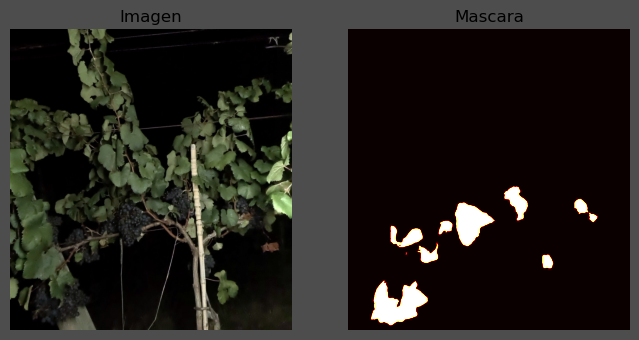

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm

import numpy as np
import numpy.random as rng

mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 150

mpl.rcParams['font.size'] = 10
mpl.rcParams['legend.fontsize'] = 'small'
mpl.rcParams['figure.titlesize'] = 'small'


plt.figure(figsize=(8,8),facecolor=(0.3,0.3,0.3))
plt.subplot(1,2,1)
plt.imshow(train_images[0])
plt.title('Imagen')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(train_masks[0],cmap='hot')
plt.title('Mascara')
plt.axis('off')
plt.show()




## PyTorch

PyTorch es una biblioteca muy popular y sofisticada para crear y entrenar modelos neuronales complejos.
En nuestro caso, los datos de entrada son _parches_ (patches) de imágenes: pequeños cuadrados de tamaño $w{\times}w$. Nosotros vamos a usar un tamaño que sea semejante al de una uva promedio en nuestras imágenes: $w=21$.

Las redes convolucionales (CNN) son un tipo de arquitectura de red neuronal que se utiliza mucho en análisis de imágenes. Una propiedad importante de las CNN es su _campo receptivo_, es decir, el tamaño de parche sobre el que realiza la inferencia. Este valor se determina de la arquitectura de la red. En el ejemplo que veremos abajo, lograremos esto mediante dos capas convolucionales.


## Carga de datos en PyTorch

Debido a su complejidad, es necesario implementar algunas estructuras auxiliares para alimentar los algoritmos de PyTorch.
Concretamente, esto se hace mediante _clases_  llamadas `DataLoader` y `DataSet`. 

Además de cargar las imágenes de esta manera, las imágenes a color (RGB o lo que sea, con varios canales de color) deben ser ingresadas de una manera particular. En general, en las bibliotecas de imágenes y dibujo de Python, las imágenes a color son un arreglo (Tensor) de la forma _ancho x largo x canales_ donde _canales_  es 3 (rojo, verde, azul).

En PyTorch, se asume que las imágenes tienen la forma _canales x ancho x largo_. Entonces hay que transponerlas de manera que queden de esa manera.

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class ImageDataset(Dataset):
    def __init__(self,images,masks):
        padding = transforms.Pad(6) # 3 veces el radio del kernel, que es 2 (5-1/2, ver abajo en la def. de la red)
        H,W,C = images[0].shape
        self.images = list(padding(torch.tensor(i.transpose((2,0,1)),dtype=torch.float32)) for i in images)
        self.masks = list(torch.tensor(i.reshape(H,W),dtype=torch.long) for i in masks)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self,idx):
        return self.images[idx],self.masks[idx]

train_dataset = ImageDataset(train_images,train_masks)
test_dataset = ImageDataset(test_images,test_masks)

train_loader = DataLoader(train_dataset,batch_size=1,shuffle=False)



## Definición del modelo neuronal

Abajo vemos cómo se construye el modelo que vamos a usar.
PENDIENTE: explicarlo mejor

In [5]:
import torch.nn as nn
import torch.nn.functional as fun

ancho_patch = 5
dim_patch = ancho_patch*ancho_patch
canales_0 = 3 # RGB
canales_1 = 16
canales_2 = 16
canales_3 = 2 # clase
clases = 1

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(canales_0, canales_1, ancho_patch)       # primera capa, mira parches de 5x5 de 6 maneras distintas (filtros)
        #self.pool1 = nn.MaxPool2d(2,2)        # esto reduce la dimensión a la mitad, lo que aumenta el campo receptivo al doble (10x10)
        self.conv2 = nn.Conv2d(canales_1, canales_2, ancho_patch)      # nuevamente, miramos parches de 5x5, pero ahora de 16 maneras distintas
        #self.pool2 = nn.MaxPool2d(2,2)        # esto reduce la dimensión a la mitad, lo que aumenta el campo receptivo al doble (5x5)
        self.conv3 = nn.Conv2d(canales_2, canales_3, ancho_patch)      # nuevamente, miramos parches de 5x5, pero ahora de 2 maneras distintas


    def forward(self, x):
        #x = self.pool1(fun.relu(self.conv1(x)))
        #x = self.pool2(fun.relu(self.conv2(x)))
        x = fun.relu(self.conv1(x))
        x = fun.relu(self.conv2(x))
        x = fun.softmax(self.conv3(x),dim=0)
        return x


net = Net()

### Entrenamiento del modelo

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.2,0.8],dtype=torch.float32))
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters())
ntrain = len(train_dataset)

prev_loss = 1
for epoch in range(100):  # loop over the dataset multiple times
    avg_loss = 0.0
    tol = 1e-3
    for j in range(ntrain):
        input,target = train_dataset.__getitem__(j)        
        output = net(input)
        optimizer.zero_grad()
        loss = criterion(output.reshape((1,*output.shape)),target.reshape(1,*target.shape))
        loss.backward()
        optimizer.step()
        loss_value = loss.item()
        avg_loss += loss_value
    avg_loss /= ntrain
    change = abs(avg_loss-prev_loss)/(1e-10+avg_loss) 
    print(f'[epoch {epoch + 1} training loss: {avg_loss:.5f} prev {prev_loss:.5f} change {change:.8f}')
    if change < tol:
        print('no further improvement.')
        break
    prev_loss = avg_loss
print('finished training')


[epoch 1 training loss: 0.68412 prev 1.00000 change 0.46172183
[epoch 2 training loss: 0.63102 prev 0.68412 change 0.08416177
[epoch 3 training loss: 0.58674 prev 0.63102 change 0.07545851
[epoch 4 training loss: 0.56618 prev 0.58674 change 0.03632637
[epoch 5 training loss: 0.55360 prev 0.56618 change 0.02271460
[epoch 6 training loss: 0.54723 prev 0.55360 change 0.01164831
[epoch 7 training loss: 0.54354 prev 0.54723 change 0.00677695
[epoch 8 training loss: 0.53736 prev 0.54354 change 0.01149685
[epoch 9 training loss: 0.52058 prev 0.53736 change 0.03224085
[epoch 10 training loss: 0.50111 prev 0.52058 change 0.03886355
[epoch 11 training loss: 0.48927 prev 0.50111 change 0.02419244
[epoch 12 training loss: 0.47833 prev 0.48927 change 0.02287101
[epoch 13 training loss: 0.47105 prev 0.47833 change 0.01545266
[epoch 14 training loss: 0.46227 prev 0.47105 change 0.01899319
[epoch 15 training loss: 0.45453 prev 0.46227 change 0.01702230
[epoch 16 training loss: 0.44712 prev 0.45453 cha

## Evaluacion



image 0 loss 0.44393855333328247
image 1 loss 0.35858872532844543
image 2 loss 0.3367322087287903
image 3 loss 0.385728120803833
image 4 loss 0.3779064118862152
imagen 0 score 0.0558


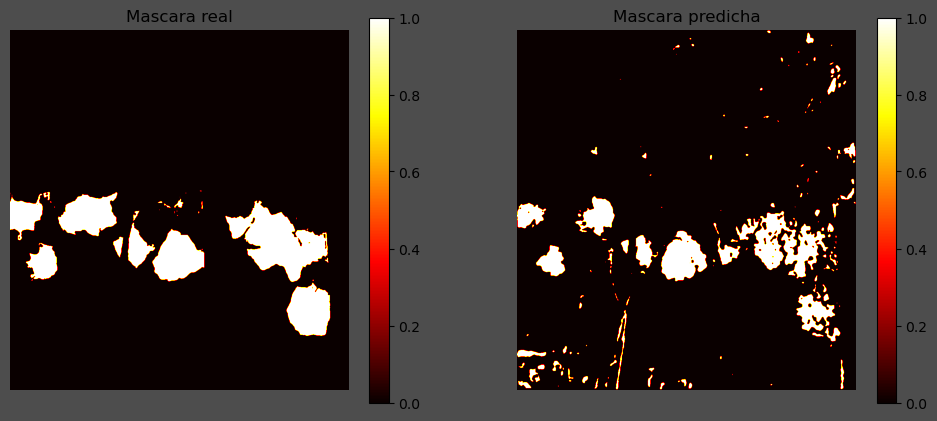

imagen 1 score 0.0195


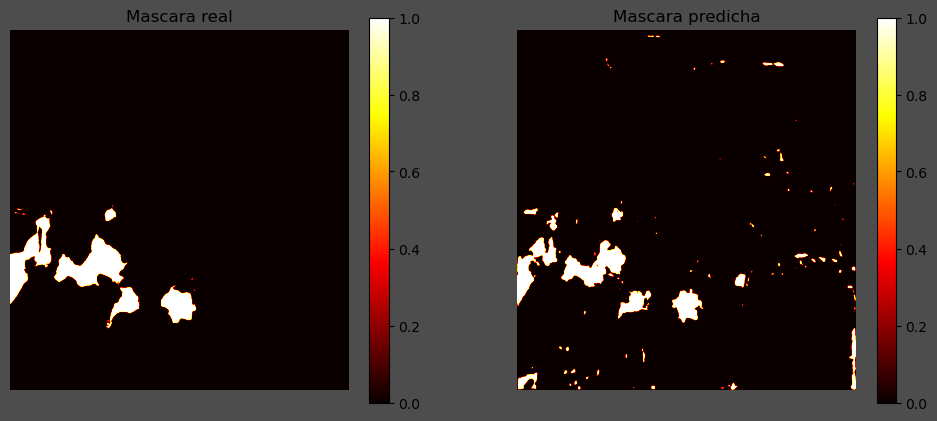

imagen 2 score 0.0130


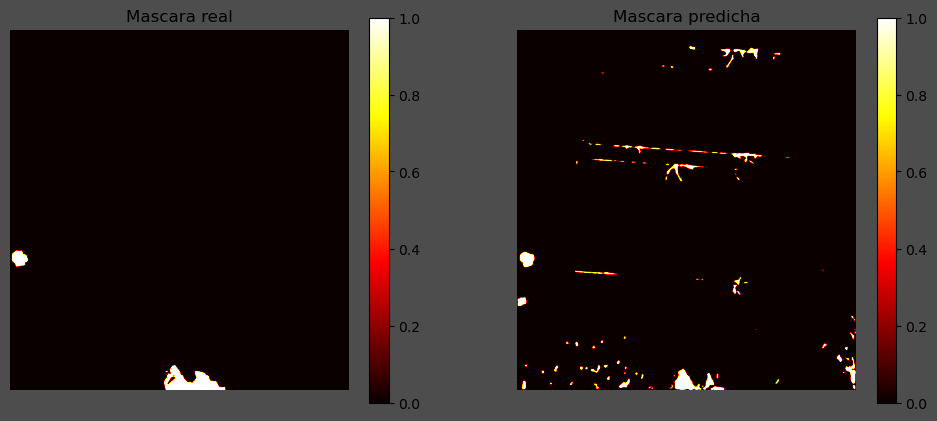

imagen 3 score 0.0375


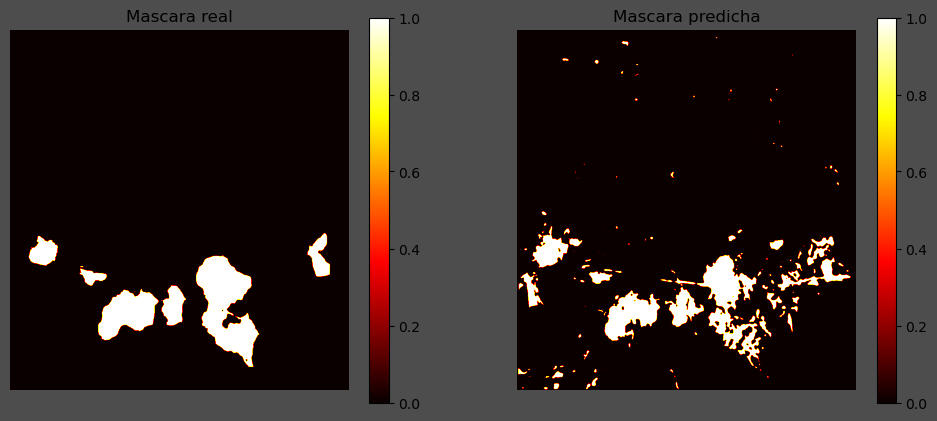

imagen 4 score 0.0327


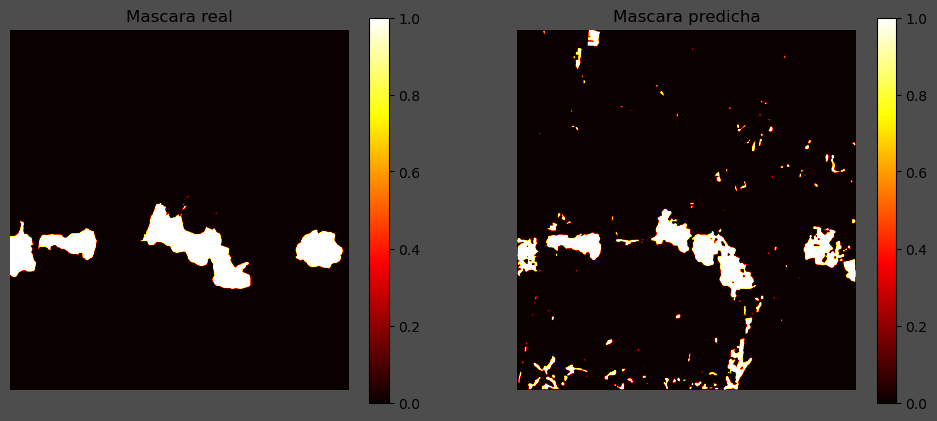

In [7]:
def eval(test_images,test_masks,predicted_masks):
    for j,I in enumerate(test_images):
        M,N,C = I.shape
        X = np.reshape(I,(M*N,C))
        true_mask = test_masks[j]
        pred_mask = predicted_masks[j]
        score = np.mean(np.abs(true_mask-pred_mask))
        print(f'imagen {j} score {score:.4f}')
        plt.figure(figsize=(12,5),facecolor=(0.3,0.3,0.3))
        plt.subplot(1,2,1)
        plt.imshow(true_mask,cmap='hot')
        plt.title('Mascara real')
        plt.colorbar()
        plt.axis('off')
        plt.subplot(1,2,2)
        plt.imshow(pred_mask,cmap='hot')
        plt.title('Mascara predicha')
        plt.axis('off')
        plt.colorbar()
        plt.show()

def apply(test_dataset):
    ntest = len(test_dataset)
    predicted_masks = []
    for j in range(ntest):
        input,target = test_dataset.__getitem__(j)
        output = net(input)        
        loss = criterion(output.reshape((1,*output.shape)),target.reshape(1,*target.shape))
        print('image',j,'loss',loss.item())
        predicted_masks.append(output.detach().numpy())
    return predicted_masks


pred_masks = apply(test_dataset)
pred_masks = [i[1,:,:].squeeze()>0.5 for i in pred_masks] # de logit a clase
eval(test_images,test_masks,pred_masks)
